In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from tensor_type import Tensor
from typing import List, Tuple, Callable, Union, Optional
import pdb

import tqdm

EPS = sys.float_info.epsilon

D = 2   # dimension
a = .05
b = 10.
Cov = torch.Tensor([[1.,0.],[0.,1.]])
Cov[0,0] *= a
Cov[1,1] *= b
iCov = torch.inverse(Cov)

def K( p, Mi=torch.eye(D)):
    return torch.squeeze( (p.t()@Mi@p)*.5 )

def U(q):
    return torch.squeeze( q.t()@iCov@q )

### Monitor Functions ($G$)
In general for function $G$,
$$G(\mathbf{y}) = -\frac{1}{\sigma(\mathbf{y})}\nabla\sigma(\mathbf{y})^{\top}f(\mathbf{y}),$$
where $\mathbf{y}$ can be $\mathbf{y}=(\mathbf{p},\mathbf{q})$ or just $\mathbf{q}$ depending on the design of $\sigma$.

**Sa. ($\sigma_a$)**<br>
$\sigma_a(\mathbf{q}) =\left((H_0-U(\mathbf{q})) + \nabla U(\mathbf{q})^{\top}\mathbf{M}^{-1}\,\nabla U(\mathbf{q})\right)^{-\frac{1}{2}} $<br>
<br>
**Sb. ($\sigma_b$)**<br>
$\sigma_b (\mathbf{q}) = (H_0 - U(\mathbf{q}))^{-\frac{1}{2}}$ <br>

**Sc. ($\sigma_c$)**<br>
$\sigma_c(\mathbf{q}) = \lvert|\mathbf{q}\rvert|^{\alpha}$, where $\alpha = 2$.

**Sd. ($\sigma_d$)**<br>
$(\mathbf{q}^{\top}\mathbf{q})^{\alpha}$, where $\alpha=\frac{3}{2}$

**Se. ($\sigma_e$)**<br>
$(\mathbf{q}^{\top}\mathbf{q})^{\alpha}$, where $\alpha=\frac{1}{2}$

**Sf. ($\sigma_f$)**<br>
$\sigma_f(\mathbf{q}) = \left(\mathbf{q}^{\top}\mathbf{q}\right)^{-\frac{\alpha}{2}}$, where $\alpha=\frac{3}{2}$ 

In [2]:
'''
def Sa(q, uq, duq, h0, Mi=torch.eye(D)):
    #pdb.set_trace()
    #print(f'In Sa:\nduq = {duq}')
    duq_sqrd = (duq.t()@Mi@duq)[0,0]
    out = 1/torch.sqrt((h0-uq) + duq_sqrd)
    #print(f'Sa out = {out}')
    return out.item()

def dSa(q, uq, duq, h0, Mi=torch.eye(D)):
    #pdb.set_trace()
    out = -3*q*Sa(q,uq, duq, h0, Mi)**3
    #print(f'In dSa:\nout = {out}')
    return out
'''
def Sb(q, uq, duq, h0):
    #pdb.set_trace()
    out = 1/(torch.sqrt(h0 - uq/2) + 1e-12)
    #print(f'Sb h0 - uq = {h0 - uq/2}')
    return out

def dSb(q, uq, duq, h0):
    out = (-.5*Sb(q, uq, duq, h0)**3)*duq
    #print(f'dSb out = {out}')
    return out
from torch.linalg import norm
def Sc(p0, q0, p, q):
    den =  norm(p0)*norm(q)-norm(q0)*norm(p)
    return 1/den

def dSc(p0, q0, p, q):
    fac1 = (-1/Sc(p0, q0, p, q)**2)
    out = fac1*(norm(p0)*q + norm(q0)*p)

In [3]:
def Ackley(x,a=20,b=.2,c=2*np.pi):
    term1 = -a*torch.exp( -b*torch.sqrt( (1/D)*(x.t()@x) ) )
    term2 = -torch.exp( (1/D)*torch.cos(c*x).t()@torch.ones((D,1)) )
    term3 = a + np.exp(1)
    return torch.squeeze(term1 + term2 + term3)

def DropWave(x):
    num = -(1. + torch.cos(12*(torch.linalg.norm(x))))
    den = .5*(x.t()@x) + 2
    return torch.squeeze(num/den)

def Holder(x):
    expon = torch.exp(torch.abs(1- torch.linalg.norm(x)/np.pi))
    return torch.squeeze(-torch.abs( torch.sin(x[0,0])*torch.cos(x[1,0])*expon ))

def Rastrigin(x):
    out = 10*D + (x**2 - 10*torch.cos(2*np.pi*x)).t()@torch.ones((2,1))
    return torch.squeeze(out/77.3) 

def gradient(func, x) -> Tuple[Tensor, Tensor]:
        '''
        *args = [Callable, Tensor, paramstofunc]
        dH calculates callable function and its gradient.
        x: tensor
        Mat: tensor (mass matrix)
        func: is a function to calculate
        returns function output and gradient
        '''
        vec = x[0]
        vec.requires_grad_(True)    # track math operations
        vec.retain_grad()           # keep gradient after backward()
        out    = func(*x)   # calculate given function
        out.backward(gradient=torch.ones(out.size()))  # Calculate grads
        vec_grad = vec.grad.data      # get gradients only
        vec.grad = None             # reset gradient 
        vec.requires_grad_(False)   # stop tracking
        return out.detach().clone(), vec_grad 

def eccentricity(smajor, sminor):
    return np.sqrt(1. - (sminor**2)/(smajor**2))

class SV:
    '''
        Assumes: 
        -potential function is given
    '''
    def __init__(self, U, h, dim):
        self.U   = U
        self.h   = h
        self.dim = dim
            
    def gradient(self,
                 func: Callable,
                 x:    Tensor) -> Tuple[Tensor, Tensor]:
        '''
        dH calculates callable function and its gradient.
        x: tensor
        Mat: tensor (mass matrix)
        func: is a function to calculate
        returns function output and gradient
        '''
        x = x[0]
        x.requires_grad_(True)    # track math operations
        x.retain_grad()           # keep gradient after backward()
        out    = func(x)          # calculate given function
        out.backward(gradient=torch.ones(out.size()))  # Calculate grads
        x_grad = x.grad.data      # get gradients only
        x.grad = None             # reset gradient 
        x.requires_grad_(False)   # stop tracking
        return out.detach().clone(), x_grad 

    def sv1(self, p,q):
                                  # half-step p
        _, g1 = self.gradient(self.U, (q,))
        p     -= .5*self.h*g1
                                  # full-step q
        q     += self.h*p
                                  # half-step p
        _, g2 = self.gradient(self.U, (q,))
        p     -= .5*self.h*g2
        
        return -p,q

class HMC():
    def __init__(self,
                 method,
                 kinetic,
                 potential,
                 dim):
        self.method = method 
        self.K      = kinetic
        self.U      = potential
        self.dim    = dim
        self.M      = torch.eye(D)
        self.Mi     = torch.inverse(self.M)
    
    #def dK(self,p):
    #    return torch.squeeze( self.Mi@p)
        
    def H(self, p, q):
        return torch.squeeze( self.K(p) + self.U(q))
    
    def alpha(self, p0,q0,pstar,qstar):
        a = torch.Tensor([1., torch.exp(self.H(p0,q0)-\
                                        self.H(pstar,qstar))])
        return (torch.min(a)).item()
    def accept(self, a, q0, qstar):
        acceptFlag = False
        u = np.random.uniform(0,1)
        if u < a:
            q0 = qstar
            acceptFlag = True
        else:
            q0 = q0
            acceptFlag = False
        return q0, acceptFlag
    
    def sample(self, q0, sd = 2., time=None, asv=False):
        p0 = torch.normal(0., sd, (2,1))        # sample normal dist
        
        if(asv):
            Pp,Qp = self.method(p0,q0, time, True)     # propagate
        else:
            Pp,Qp = self.method(p0,q0)     # propagate
            
        acc = self.alpha(p0,q0,Pp,Qp)  # get acceptance prob
        return  self.accept(acc, q0, Qp)    # accept/reject

In [4]:
class ASV:
    '''
        Assumes: 
        -potential function is given
        -potential is differentiable
    '''
    def __init__(self, grad, K, U, S, dS, h, dim):
        self.grad = grad
        self.K    = K  # kinetic energy
        self.U    = U  # potential energy
        self.S    = S  # sigma function
        self.dS   = dS # derivative of sigma
        self.h    = h  # step-size
        self.dim  = dim  # dim
    
    def H(self, p ,q):
        """
            Hamiltonian a.k.a. Total Energy of system
        """
        return torch.squeeze(self.K(p) + self.U(q))
    
    def cos_similarity(self, q1, q2):
        """
            Correlation criteria to stop propagation.
        """
        num = (q1.t()@q2)
        den = norm(q1)*norm(q2) + 1e-3
        sim = (num/den).item()
        
        if((sim>EPS) and (sim <= .3)):
            out = False
        else:
            out = True
        return out
           
    def G(self,
          p,
          q,
         h0=None) -> Tensor:
        """
            Monitor function implementing sigma
        """
        uq, duq = self.grad(self.U, (q,))
        out = ((-1/self.S(q, uq, duq, h0)) *
               (self.dS(q, uq, duq, h0).t()@p))
        return out[0,0]

    def asv1(self, p,q, time, useH0 = False):
        """
            Adaptive step SV implementation
        """
        simFlag = True
        totalSteps = 0.
        H0 = self.H(p,q)
        if(useH0):
            z = 1 - (self.h/2.)*self.G(p,q,H0)
        else:
            z = 1 - (self.h/2.)*self.G(p,q)
        
        q0 = q.detach().clone()
        while(simFlag):  # Exit if de-correlated
            
            if(useH0):
                z = z + self.h*self.G(p,q,H0)
            else:
                z = z + self.h*self.G(p,q)
                                      # half-step p
            _, du1 = self.grad(self.U, (q,))
            p     -= .5*self.h*du1/z
                                      # full-step q
            _, dk1 = self.grad(self.K, (p,))
            q     += self.h*dk1/z
                                    # half-step p
            _, du2 = self.grad(self.U, (q,))
            p     -= .5*self.h*du2/z
            
            totalSteps += 1 #self.h/z
            # Failing de-corr exit on step count
            # Forces a resampling of momentum
            if(totalSteps > 200):  
                break
            # Check new point
            simFlag = self.cos_similarity(q0, q)
        #print(f'Total steps = {totalSteps}  ','*'*50)

        return -p,q

### General observation

Set a low fundamental step size and a wide proposal distribution.

### 2-dimensional Gaussian 
$Cov = \begin{bmatrix}
.05 & 0\\
 0 & 10
\end{bmatrix}$

In [30]:
H = .01  # stepsize
Nprops = 2000

In [31]:

sv = SV(U,H,D)
hmc = HMC(sv.sv1, K, U, D)

q0 = torch.Tensor([[10.],[10.]])
samplesSV_Gauss = np.zeros((D,Nprops))
acceptance_countSV = 0

for n in tqdm.tqdm(range(Nprops)):
    q0, accFlag = hmc.sample(q0)
    if(accFlag):
        acceptance_countSV += 1
    samplesSV_Gauss[:,n] = q0.numpy()[:,0]

100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1718.79it/s]


In [32]:
asv = ASV(gradient, K, U, Sb, dSb, H, D)
hmc = HMC(asv.asv1, K, U, D)
q0 = torch.Tensor([[10.],[10.]])
samplesASV_Gauss = np.zeros((D,Nprops))
acceptance_countASV = 0

for n in tqdm.tqdm(range(Nprops)):
    q0, accFlag = hmc.sample(q0, 1, True)
    if(accFlag):
        acceptance_countASV += 1
    samplesASV_Gauss[:,n] = q0.numpy()[:,0]

100%|███████████████████████████████████████| 2000/2000 [03:25<00:00,  9.73it/s]


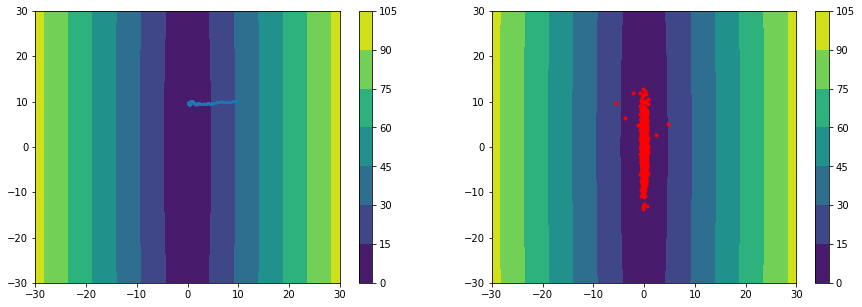

 Acceptance rate SV = 1.0
 Acceptance rate ASV = 1.0


In [36]:
bnd = 30
delta = 0.025

x = np.arange(-bnd, bnd, delta)
y = np.arange(-bnd, bnd, delta)
X, Y = np.meshgrid(x, y)
Z = np.sqrt(b*X**2 + a*Y**2)

fig, ax = plt.subplots(1,2,figsize=(15,5))
cs0 = ax[0].contourf(X, Y, Z)
fig.colorbar(cs0, ax=ax[0])
ax[0].scatter(samplesSV_Gauss[0,:],samplesSV_Gauss[1,:], s=.5)
ax[0].set_xlim(-bnd,bnd)
ax[0].set_ylim(-bnd,bnd)



cs1 = ax[1].contourf(X, Y, Z)
fig.colorbar(cs1, ax=ax[1])
ax[1].plot(samplesASV_Gauss[0,:],samplesASV_Gauss[1,:], '.r')
ax[1].set_xlim(-bnd,bnd)
ax[1].set_ylim(-bnd,bnd)
plt.show()

print(f' Acceptance rate SV = {acceptance_countSV/Nprops}')
print(f' Acceptance rate ASV = {acceptance_countASV/Nprops}')

### Ackley

$$f(\mathbf{x} = -a\exp\left( -b\lvert|\mathbf{x}\rvert| \right)- \exp\left( \frac{1}{D}\cos(c\mathbf{x})^{\top}\cdot \mathbb{1}\right) + a + \exp(1),$$<br>
where $D$ is dimension and parameters $a=20$, $b=.2$, and $c=2\pi$.<br>
Global minimum $f(\mathbf{x^{*}})=0$ at $\mathbf{x}^* = \mathbf{0}$

In [7]:
H = .01  # stepsize
Nprops = 2000

In [8]:
sv = SV(Ackley,H,D)
hmc = HMC(sv.sv1, K, Ackley, D)

q0 = torch.Tensor([[20.],[0.]])
samplesSV_Ackley = np.zeros((D,Nprops))
acceptance_countSV = 0

for n in tqdm.tqdm(range(Nprops)):
    q0, accFlag = hmc.sample(q0)
    if(accFlag):
        acceptance_countSV += 1
    samplesSV_Ackley[:,n] = q0.numpy()[:,0]

100%|██████████████████████████████████████| 2000/2000 [00:02<00:00, 799.04it/s]


In [9]:
#Sigma-b
asv = ASV(gradient, K, Ackley, Sb, dSb, H, D)
hmc = HMC(asv.asv1, K, Ackley, D)
q0 = torch.Tensor([[20.],[0.]])
samplesASV_Ackley = np.zeros((D,Nprops))
acceptance_countASV = 0

for n in tqdm.tqdm(range(Nprops)):
    q0, accFlag = hmc.sample(q0, 1, True)
    if(accFlag):
        acceptance_countASV += 1
    samplesASV_Ackley[:,n] = q0.numpy()[:,0]

100%|███████████████████████████████████████| 2000/2000 [08:21<00:00,  3.99it/s]


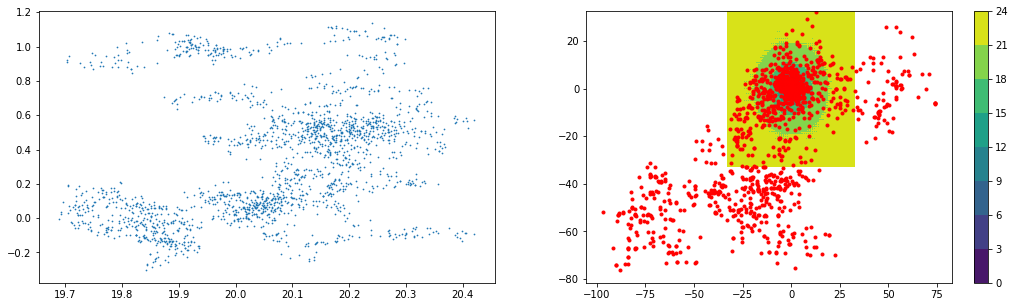

 Acceptance rate SV = 1.0
 Acceptance rate ASV = 1.0


In [10]:
bnd = 32.7
delta = .1
a = 20.
b = .2
c = 2*np.pi

x = np.arange(-bnd, bnd, delta)
y = np.arange(-bnd, bnd, delta)
X, Y = np.meshgrid(x, y)

Z = -a*np.exp(-b*np.sqrt((1/D)*(X**2 + Y**2))) -\
    np.exp((1/D)*(np.cos(c*X)+np.cos(c*Y))) +\
    a + np.exp(1)

fig, ax = plt.subplots(1,2,figsize=(18,5))

cs0 = ax[0].contourf(X, Y, Z)
fig.colorbar(cs0, ax=ax[0])
ax[0].scatter(samplesSV_Ackley[0,:],samplesSV_Ackley[1,:], s=.5)
ax[0].set_xlim(-bnd,bnd)
ax[0].set_ylim(-bnd,bnd)

cs1 = ax[1].contourf(X, Y, Z)
fig.colorbar(cs1, ax=ax[1])
ax[1].plot(samplesASV_Ackley[0,:],samplesASV_Ackley[1,:], '.r')
ax[1].set_xlim(-bnd,bnd)
ax[1].set_ylim(-bnd,bnd)

plt.show()

print(f' Acceptance rate SV = {acceptance_countSV/Nprops}')
print(f' Acceptance rate ASV = {acceptance_countASV/Nprops}')

### Observation
- Regardless of small step-size HMC drifted strongly away from the origin and global minimum located there.
- The extremely small local minima away from the origin likely affect the gradient vector strongly depending on initialization location of $\mathbf{q}$. Meaning anunlucky choice of $\mathbf{q}_0$ could affect the direction of trajectory in phase space.
- To check effect of minima need to examine a contour plot of the sigma function in the flatter outer region.

### Dropwave
$$ f(\mathbf{x}) = -\frac{1+\cos\left( 12\lvert|\mathbf{x}\rvert|\right)}{0.5(\mathbf{x}^{\top}\mathbf{x}) + 2} $$<br>
Global minimum $f(\mathbf{x^{*}})=-1$, at $\mathbf{x}^{*}=(0,0)$


In [10]:
H = .01
Nprops = 2000
sv = SV(DropWave,H,D)
hmc = HMC(sv.sv1, K, DropWave, D)

q0 = torch.Tensor([[2.9],[0.]])
samplesSV_Drop = np.zeros((D,Nprops))
acceptance_countSV = 0

for n in tqdm.tqdm(range(Nprops)):
    q0, accFlag = hmc.sample(q0, 1.)
    if(accFlag):
        acceptance_countSV += 1
    samplesSV_Drop[:,n] = q0.numpy()[:,0]

100%|██████████████████████████████████████| 2000/2000 [00:02<00:00, 989.43it/s]


In [8]:
#Sigma-b
asv = ASV(gradient, K, DropWave, Sb, dSb, H, D)
hmc = HMC(asv.asv1, K, DropWave, D)
q0 = torch.Tensor([[2.9],[0.]])
samplesASV_Drop = np.zeros((D,Nprops))
acceptance_countASV = 0

for n in tqdm.tqdm(range(Nprops)):
    q0, accFlag = hmc.sample(q0, 1., 1, True)
    if(accFlag):
        acceptance_countASV += 1
    samplesASV_Drop[:,n] = q0.numpy()[:,0]

100%|███████████████████████████████████████| 2000/2000 [09:13<00:00,  3.61it/s]


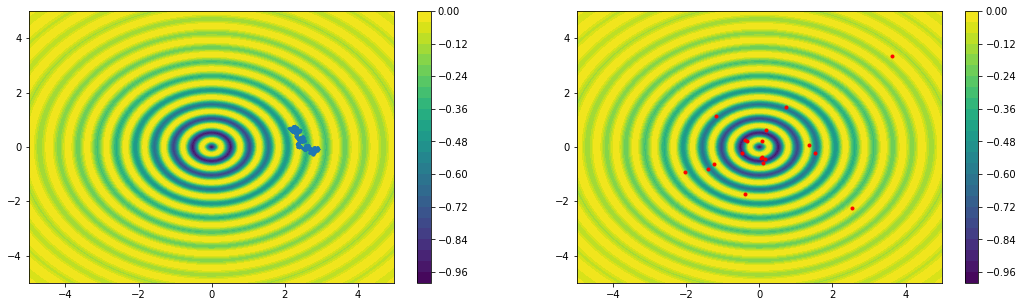

 Acceptance rate SV = 1.0
 Acceptance rate ASV = 1.0


In [11]:
bnd = 5
delta = .01

x = np.arange(-bnd, bnd, delta)
y = np.arange(-bnd, bnd, delta)
X, Y = np.meshgrid(x, y)

Z = -(1 + np.cos(12*np.sqrt(X**2 + Y**2)))/(.5*(X**2 + Y**2) + 2)

fig, ax = plt.subplots(1,2,figsize=(18,5))

cs0 = ax[0].contourf(X, Y, Z, levels=30)
fig.colorbar(cs0, ax=ax[0])
ax[0].scatter(samplesSV_Drop[0,:],samplesSV_Drop[1,:], s=.5)
ax[0].set_xlim(-bnd,bnd)
ax[0].set_ylim(-bnd,bnd)

cs1 = ax[1].contourf(X, Y, Z, levels=30)
fig.colorbar(cs1, ax=ax[1])
ax[1].plot(samplesASV_Drop[0,:],samplesASV_Drop[1,:], '.r')
ax[1].set_xlim(-bnd,bnd)
ax[1].set_ylim(-bnd,bnd)

plt.show()
print(f' Acceptance rate SV = {acceptance_countSV/Nprops}')
print(f' Acceptance rate ASV = {acceptance_countASV/Nprops}')

### Observation 
- For dropwave it appears the momentum proposal distribution (Gaussian) needed its variance widened to $SD=2.$, AHMC sampled a greater range of momentum -> energy -> is able to bypass the inner potential wall and get to the minimum second ring.

- Shortened step is required to stop both HMC and AHMC from wandering away from the minimum.

- For larger step HMC appears to explore randomly. Smaller step means HMC stays nearly in place.

- With $SD=3.$ HMC found the central minimum.

### Holder

$f(\mathbf{x}) = -\left| \sin(x_1)\cos(x_2) \exp\left(\left|1-\frac{\lVert \mathbf{x}\rVert}{\pi}\right|\right)\right|$<br>

Global minimum $f(\mathbf{x}^*)=-19.021$ at four corners when evaluated as is common on a 10 by 10 square.

In [52]:
H = .01
sv = SV(Holder,H,D)
hmc = HMC(sv.sv1, K, Holder, D)
Nprops = 1000

q0 = torch.Tensor([[5.],[5.]])
samplesSV_Holder = np.zeros((D,Nprops))
acceptance_countSV = 0

for n in tqdm.tqdm(range(Nprops)):
    q0, accFlag = hmc.sample(q0)
    if(accFlag):
        acceptance_countSV += 1
    samplesSV_Holder[:,n] = q0.numpy()[:,0]

100%|██████████████████████████████████████| 1000/1000 [00:01<00:00, 874.62it/s]


In [56]:
#Sigma-b
asv = ASV(gradient, K, Holder, Sb, dSb, H, D)
hmc = HMC(asv.asv1, K, Holder, D)
q0 = torch.Tensor([[5.],[5.]])
samplesASV_Holder = np.zeros((D,Nprops))
acceptance_countASV = 0

for n in tqdm.tqdm(range(Nprops)):
    q0, accFlag = hmc.sample(q0, .5 ,1, True)
    if(accFlag):
        acceptance_countASV += 1
    samplesASV_Holder[:,n] = q0.numpy()[:,0]

100%|███████████████████████████████████████| 1000/1000 [04:53<00:00,  3.40it/s]


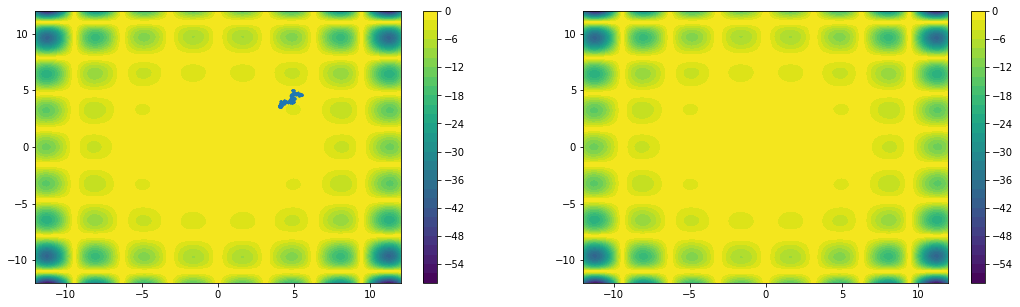

 Acceptance rate SV = 1.0
 Acceptance rate ASV = 0.0


In [59]:
bnd = 12.
delta = .01

x = np.arange(-bnd, bnd, delta)
y = np.arange(-bnd, bnd, delta)
X, Y = np.meshgrid(x, y)

Z = -np.abs( np.sin(X)*np.cos(Y)*np.exp(np.abs(1 - np.sqrt(X**2 + Y**2)/np.pi)) )

fig, ax = plt.subplots(1,2,figsize=(18,5))

cs0 = ax[0].contourf(X, Y, Z, levels=30)
fig.colorbar(cs0, ax=ax[0])
ax[0].scatter(samplesSV_Holder[0,:],samplesSV_Holder[1,:], s=.5)
ax[0].set_xlim(-bnd,bnd)
ax[0].set_ylim(-bnd,bnd)

cs1 = ax[1].contourf(X, Y, Z, levels=30)
fig.colorbar(cs1, ax=ax[1])
ax[1].plot(samplesASV_Holder[0,:],samplesASV_Holder[1,:], '.r')
ax[1].set_xlim(-bnd,bnd)
ax[1].set_ylim(-bnd,bnd)

plt.show()

print(f' Acceptance rate SV = {acceptance_countSV/Nprops}')
print(f' Acceptance rate ASV = {acceptance_countASV/Nprops}')

### Observation
Minimuma at corners deepen to infinity as $\lVert \mathbf{x}\rVert \rightarrow \infty$. AHMC seems to go to infinity accordingly.

### Rastrigan

$$f(\mathbf{x}) = 10 D + [\mathbf{x}^2 - 10 \cos(2\pi\mathbf{x})]^{\top}\cdot\mathbb{1},$$<br>
where $D$ is dimension and $\mathbb{1}$ is a vector of ones.<br>
Global minimum $f(\mathbf{x}^*)=0$ at $\mathbf{x}^* = \mathbf{0}$.

In [19]:
H = .01
Nprops = 2000
sv = SV(Rastrigin,H,D)
hmc = HMC(sv.sv1, K, Rastrigin, D)

q0 = torch.Tensor([[3.],[0.]])
samplesSV_Rast = np.zeros((D,Nprops))
acceptance_countSV = 0

for n in tqdm.tqdm(range(Nprops)):
    q0, accFlag = hmc.sample(q0)
    if(accFlag):
        acceptance_countSV += 1
    samplesSV_Rast[:,n] = q0.numpy()[:,0]

100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1097.07it/s]


In [20]:
#Sigma-b
asv = ASV(gradient, K, Rastrigin, Sb, dSb, H, D)
hmc = HMC(asv.asv1, K, Rastrigin, D)
q0 = torch.Tensor([[3.],[0.]])
samplesASV_Rast = np.zeros((D,Nprops))
acceptance_countASV = 0

for n in tqdm.tqdm(range(Nprops)):
    q0, accFlag = hmc.sample(q0, 1, True)
    if(accFlag):
        acceptance_countASV += 1
    samplesASV_Rast[:,n] = q0.numpy()[:,0]

100%|███████████████████████████████████████| 2000/2000 [08:00<00:00,  4.17it/s]


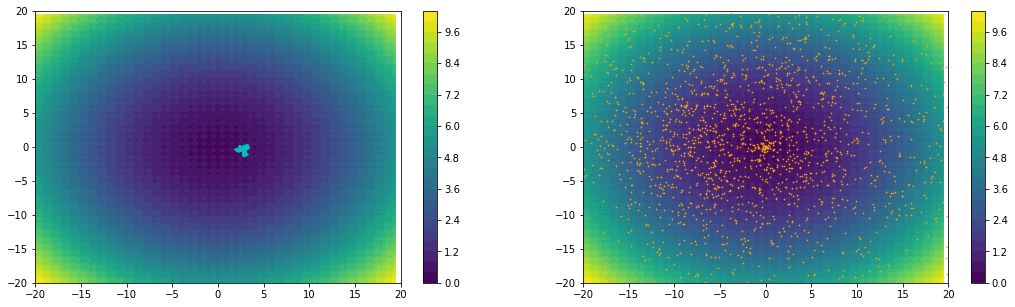

 Acceptance rate SV = 1.0
 Acceptance rate ASV = 1.0


In [21]:
bnd = 20
delta = .5

x = np.arange(-bnd, bnd, delta)
y = np.arange(-bnd, bnd, delta)
X, Y = np.meshgrid(x, y)

Z = (10*D + (X**2 -10*np.cos(2*np.pi*X)) + (Y**2 -10*np.cos(2*np.pi*Y)))
fig, ax = plt.subplots(1,2,figsize=(18,5))

cs0 = ax[0].contourf(X, Y, Z/77.3, levels=30)
fig.colorbar(cs0, ax=ax[0])
ax[0].scatter(samplesSV_Rast[0,:],samplesSV_Rast[1,:], s=.5, c='c')
ax[0].set_xlim(-bnd,bnd)
ax[0].set_ylim(-bnd,bnd)

cs1 = ax[1].contourf(X, Y, Z/77.3, levels=30)
fig.colorbar(cs1, ax=ax[1])
ax[1].scatter(samplesASV_Rast[0,:],samplesASV_Rast[1,:], s=.5, c= 'orange')
ax[1].set_xlim(-bnd,bnd)#
ax[1].set_ylim(-bnd,bnd)

plt.show()
print(f' Acceptance rate SV = {acceptance_countSV/Nprops}')
print(f' Acceptance rate ASV = {acceptance_countASV/Nprops}')

### Observation
Global Min found and basin explored.